In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.quantum_info import Pauli, PauliList, SparsePauliOp
from qiskit_machine_learning.optimizers import BasinHopping
import os

In [2]:
num_qubits = 10
split = 1
path = '/Users/choyboy/Documents/Python/QML'
df = pd.read_excel(f'{path}/hydrocarbon_series.xlsx', sheet_name='normalised_data_0_5')
classes = df['Phase (373K)'].to_numpy()
smiles = df['SMILES'].to_numpy()
enthalpy = df['Gas Formation Enthalpy'].to_numpy()
df_train_indices = pd.read_excel(f'{path}/hydrocarbon_series.xlsx', sheet_name='train_split', header=None).to_numpy()
df_train_split = df_train_indices[:,split-1] - 1
df_train_smiles = smiles[df_train_split]
df_train_classes = classes[df_train_split]
df_test_indices = pd.read_excel(f'{path}/hydrocarbon_series.xlsx', sheet_name='test_split', header=None).to_numpy()
df_test_split = df_test_indices[:,split-1] - 1
df_test_smiles = smiles[df_test_split]
df_test_classes = classes[df_test_split]
df_train_enthalpy = enthalpy[df_train_split]
df_test_enthalpy = enthalpy[df_test_split]
num_train_points = df_train_classes.shape[0]
num_test_points = df_test_classes.shape[0]
for i in range(num_train_points):
    if df_train_classes[i] == 0:
        df_train_classes[i] = -1
for i in range(num_test_points):
    if df_test_classes[i] == 0:
        df_test_classes[i] = -1

In [3]:
def coulomb_matrix(smiles: str, add_hydrogens: bool = False, bond_coupling: float = 1.0, atom_factor: float = 2.4) -> np.ndarray:
    """
    Computes the adjacent Coulomb matrix for a given molecule specified by a SMILES string,
    using specific average bond lengths for adjacent atom pairs.
    
    Parameters:
    - smiles (str): The SMILES string representing the molecule.
    - add_hydrogens (bool): Whether to add hydrogen atoms to the molecule.
    
    Returns:
    - np.ndarray: The Coulomb matrix of the molecule.
    """
    # Load the molecule from the SMILES string
    molecule = Chem.MolFromSmiles(smiles)
    
    # Add hydrogen atoms if specified
    if add_hydrogens == True:
        molecule = Chem.AddHs(molecule)
    
    # Get the atomic numbers of the atoms
    atomic_numbers = [atom.GetAtomicNum() for atom in molecule.GetAtoms()]
    
    # Number of atoms
    num_atoms = len(atomic_numbers)
    
    # Initialize the Coulomb matrix
    coulomb_matrix = np.zeros((num_atoms, num_atoms))
    
    # Fill in the Coulomb matrix
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                # Diagonal elements: 0.5 * Z_i^2.4
                coulomb_matrix[i, j] = (0.5 * atomic_numbers[i] ** atom_factor) 
            else:
                # Find the bond between atoms i and j
                bond = molecule.GetBondBetweenAtoms(i, j)
                if bond:
                    bond_type = bond.GetBondType()
                    if bond_type == Chem.rdchem.BondType.SINGLE:
                        distance = 1
                    elif bond_type == Chem.rdchem.BondType.DOUBLE:
                        distance = 2
                    elif bond_type == Chem.rdchem.BondType.TRIPLE:
                        distance = 3
                    elif bond_type == Chem.rdchem.BondType.AROMATIC:
                        distance = 1.5
                    coulomb_matrix[i, j] = (atomic_numbers[i] * atomic_numbers[j] / distance) * bond_coupling 
    
    return coulomb_matrix

In [4]:
def matrix_to_circuit(matrix, num_qubits, n_layers: int = 1, reverse_bits: bool = False, initial_layer: str = 'rx', entangling_layer: str = 'rzz', n_atom_to_qubit: int = 1, interleaved: str = None) -> QuantumCircuit:
    """
    Converts a matrix to a QuantumCircuit object.
    
    Parameters:
    - matrix (np.ndarray): The matrix to convert.
    
    Returns:
    - QuantumCircuit: The QuantumCircuit object representing the matrix.
    """
    # Get the number of qubits required to represent the matrix
    matrix_size = matrix.shape[0]

    # Toggle reverse bits
    if reverse_bits == True:
        m = np.flip(np.arange(num_qubits - matrix_size * n_atom_to_qubit, num_qubits))
    else:
        m = np.arange(0, matrix_size * n_atom_to_qubit)
    
    m = np.reshape(m, (matrix_size, n_atom_to_qubit))

    # Initialize the QuantumCircuit object
    qc = QuantumCircuit(num_qubits)

    for _ in range(n_layers):
        for i in range(matrix_size):
            if initial_layer == 'ry':
                for k in range(n_atom_to_qubit):
                    qc.ry(matrix[i, i], m[i, k])
            elif initial_layer == 'rz':
                for k in range(n_atom_to_qubit):
                    qc.rz(matrix[i, i], m[i, k])
            else:
                for k in range(n_atom_to_qubit):
                    qc.rx(matrix[i, i], m[i, k])
        if interleaved == 'cnot' or interleaved == 'cx':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.cx(a[j], a[j + 1])
        elif interleaved == 'cz':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.cz(a[j], a[j + 1])
        elif interleaved == 'rxx':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.rxx(matrix[i, i], a[j], a[j + 1])
        elif interleaved == 'ryy':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.ryy(matrix[i, i], a[j], a[j + 1])
        elif interleaved == 'rzz':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.rzz(matrix[i, i], a[j], a[j + 1])
        for i in range(matrix_size):
            for j in range(matrix_size):
                if (i < j) and (matrix[i, j] != 0.0):
                    if n_atom_to_qubit == 1:
                        q_c = m[i]
                        q_t = m[j]
                        if entangling_layer == 'rxx':
                            qc.rxx(matrix[i, j], q_c, q_t)
                        elif entangling_layer == 'ryy':
                            qc.ryy(matrix[i, j], q_c, q_t)
                        else:
                            qc.rzz(matrix[i, j], q_c, q_t)
                    else:
                        q_c = m[i, -1]
                        q_t = m[j, 0]
                        if entangling_layer == 'rxx':
                            qc.rxx(matrix[i, j], q_c, q_t)
                        elif entangling_layer == 'ryy':
                            qc.ryy(matrix[i, j], q_c, q_t)
                        else:
                            qc.rzz(matrix[i, j], q_c, q_t)
    
    return qc

In [5]:
def inverted_matrix_to_circuit(matrix, num_qubits, n_layers: int = 1, reverse_bits: bool = False, initial_layer: str = 'rx', entangling_layer: str = 'rzz', n_atom_to_qubit: int = 1, interleaved: str = None, hadamard: bool = False) -> QuantumCircuit:
    """
    Converts a matrix to a QuantumCircuit object.
    
    Parameters:
    - matrix (np.ndarray): The matrix to convert.
    
    Returns:
    - QuantumCircuit: The QuantumCircuit object representing the matrix.
    """
    # Get the number of qubits required to represent the matrix
    matrix_size = matrix.shape[0]

    # Toggle reverse bits
    if reverse_bits == True:
        m = np.flip(np.arange(num_qubits - matrix_size * n_atom_to_qubit, num_qubits))
    else:
        m = np.arange(0, matrix_size * n_atom_to_qubit)
    
    m = np.reshape(m, (matrix_size, n_atom_to_qubit))

    # Initialize the QuantumCircuit object
    qc = QuantumCircuit(num_qubits)

    # if hadamard == True:
    #     for i in range(matrix_size):
    #         for k in range(n_atom_to_qubit):
    #             qc.h(m[i, k])

    for _ in range(n_layers):
        # for i in range(matrix_size):
        #     for j in range(matrix_size):
        #         if (i < j) and (matrix[i, j] != 0.0):
        #             if n_atom_to_qubit == 1:
        #                 q_c = m[i]
        #                 q_t = m[j]
        #                 if entangling_layer == 'rxx':
        #                     qc.rxx(matrix[i, j], q_c, q_t)
        #                 elif entangling_layer == 'ryy':
        #                     qc.ryy(matrix[i, j], q_c, q_t)
        #                 else:
        #                     qc.rzz(matrix[i, j], q_c, q_t)
        #             else:
        #                 q_c = m[i, -1]
        #                 q_t = m[j, 0]
        #                 if entangling_layer == 'rxx':
        #                     qc.rxx(matrix[i, j], q_c, q_t)
        #                 elif entangling_layer == 'ryy':
        #                     qc.ryy(matrix[i, j], q_c, q_t)
        #                 else:
        #                     qc.rzz(matrix[i, j], q_c, q_t)

        # if interleaved == 'cnot' or interleaved == 'cx':
        #     for i in range(matrix_size):
        #         a = m[i, :]
        #         for j in range(len(a) - 1):
        #             qc.cx(a[j], a[j + 1])
        # elif interleaved == 'cz':
        #     for i in range(matrix_size):
        #         a = m[i, :]
        #         for j in range(len(a) - 1):
        #             qc.cz(a[j], a[j + 1])
        # elif interleaved == 'rxx':
        #     for i in range(matrix_size):
        #         a = m[i, :]
        #         for j in range(len(a) - 1):
        #             qc.rxx(matrix[i, i], a[j], a[j + 1])
        # elif interleaved == 'ryy':
        #     for i in range(matrix_size):
        #         a = m[i, :]
        #         for j in range(len(a) - 1):
        #             qc.ryy(matrix[i, i], a[j], a[j + 1])
        # elif interleaved == 'rzz':
        #     for i in range(matrix_size):
        #         a = m[i, :]
        #         for j in range(len(a) - 1):
        #             qc.rzz(matrix[i, i], a[j], a[j + 1])
        
        for i in range(matrix_size):
            if initial_layer == 'ry':
                for k in range(n_atom_to_qubit):
                    qc.ry(matrix[i, i], m[i, k])
            elif initial_layer == 'rz':
                for k in range(n_atom_to_qubit):
                    qc.rz(matrix[i, i], m[i, k])
            else:
                for k in range(n_atom_to_qubit):
                    qc.rx(matrix[i, i], m[i, k])
                    # qc.x(m[i, k])


    
    return qc

In [6]:
train_circuits = []
test_circuits = []
initial_layer = 'ry'
entangling_layer = 'rxx'
feature_layers = 1

for i in range(num_train_points):
    cm_train = coulomb_matrix(df_train_smiles[i], add_hydrogens=False, atom_factor=3)
    circuit_train = matrix_to_circuit(cm_train, num_qubits, n_layers=feature_layers, initial_layer=initial_layer, entangling_layer=entangling_layer)
    # circuit_train = inverted_matrix_to_circuit(cm_train, num_qubits, n_layers=feature_layers, initial_layer=initial_layer, entangling_layer=entangling_layer, hadamard=True)
    train_circuits.append(circuit_train)
for i in range(num_test_points):
    cm_test = coulomb_matrix(df_test_smiles[i], add_hydrogens=False, atom_factor=3)
    circuit_test = matrix_to_circuit(cm_test, num_qubits, n_layers=feature_layers, initial_layer=initial_layer, entangling_layer=entangling_layer)
    # circuit_test = inverted_matrix_to_circuit(cm_test, num_qubits, n_layers=feature_layers, initial_layer=initial_layer, entangling_layer=entangling_layer, hadamard=True)
    test_circuits.append(circuit_test)

In [54]:
ansatz_layers = 6
maxiter = 1000
global_operator = Pauli(("Z") * num_qubits)
# local_operator = SparsePauliOp.from_sparse_list([("Z", [i], 1/num_qubits) for i in range(num_qubits)], num_qubits=num_qubits)
# loss = 'absolute_error'
two_local_initial_layer = 'ry'
two_local_entangling_layer = 'cz'
ansatz_entanglement = 'reverse_linear'
bh_iterations = 5
max_runs = maxiter / bh_iterations
bh_stepsize = 0.5
bh_temp = 1

# ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=ansatz_entanglement, reps=ansatz_layers, skip_final_rotation_layer=True)
ansatz = TwoLocal(num_qubits, two_local_initial_layer, two_local_entangling_layer, reps=ansatz_layers, entanglement=ansatz_entanglement, skip_final_rotation_layer=True)
estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)

# Noisy simulation
# estimator_qnn = EstimatorQNN(circuit=ansatz, estimator=NoisyEstimator(), input_params=None, observables=operator)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

initial_point = (np.random.random(ansatz.num_parameters) - 0.5) * 2 * np.pi 
# initial_point = np.zeros(ansatz.num_parameters)

#construct neural network classifier

# estimator_classifier = NeuralNetworkClassifier(
#     estimator_qnn, optimizer=COBYLA(maxiter=maxiter), callback=callback_graph, initial_point=initial_point)

#Basin-hopping

x_total = []
f_total = []
accept_total = []

class MyTakeStep:
   def __init__(self, stepsize=0.5):
       self.stepsize = stepsize
       self.rng = np.random.default_rng()
   def __call__(self, x):
       s = self.stepsize
       x[0] += self.rng.uniform(-2.*s, 2.*s)
       x[1:] += self.rng.uniform(-s, s, x[1:].shape)
       return x
   
mytakestep = MyTakeStep()

def bh_callback(x, f, accept):
    x_total.append(x)
    f_total.append(f)
    accept_total.append(accept)

opt = BasinHopping(
    minimizer_kwargs={"method": 'COBYLA', "jac": False, "options": {"maxiter": max_runs}},
    options=dict(niter=bh_iterations - 1, stepsize=bh_stepsize, callback=bh_callback, T=bh_temp)
)

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=opt, callback=callback_graph, initial_point=initial_point)

newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}/ra_global/split{split}'
# newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}/{two_local_initial_layer}_{two_local_entangling_layer}/split{split}'
# newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}/{two_local_initial_layer}_{two_local_entangling_layer}_full/split{split}'

if not os.path.exists(newpath):
    os.makedirs(newpath)

/var/folders/r2/htkf_rds4gv13rqp6zvxsrkh0000gn/T/ipykernel_4084/4278125694.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)


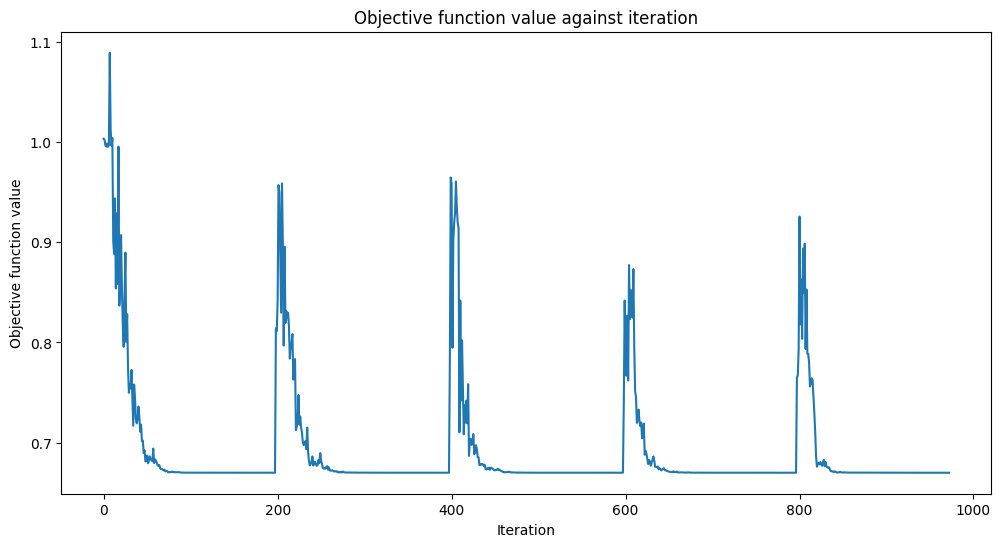

Training score= 0.75
Test score= 0.8


In [52]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(train_circuits, df_train_classes)
#Replace df_train_angle with list of feature map circuits

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print('Training score=', estimator_classifier.score(train_circuits, df_train_classes))
print('Test score=', estimator_classifier.score(test_circuits, df_test_classes))


# estimator_classifier.save(f'{newpath}/a{ansatz_layers}_m{int(maxiter/1000)}k')

In [ ]:
# If basinhopping is used, use the additional following code to use the best parameters found

min_ind = f_total.index(min(f_total))
min_x = x_total[min_ind]
print(f_total)
print(accept_total)
# print(min_ind)

est = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=1), initial_point=min_x)

est.fit(train_circuits, df_train_classes)
print('Training score=', est.score(train_circuits, df_train_classes))
print('Test score=', est.score(test_circuits, df_test_classes))

In [29]:
ansatz_layers = 7
maxiter = 2000
global_operator = Pauli(("Z") * num_qubits)
# local_operator = SparsePauliOp.from_sparse_list([("Z", [i], 1/num_qubits) for i in range(num_qubits)], num_qubits=num_qubits)
# loss = 'absolute_error'
two_local_initial_layer = 'ry'
two_local_entangling_layer = 'cz'
ansatz_entanglement = 'full'
bh_iterations = 10
max_runs = maxiter / bh_iterations
bh_stepsize = 0.01
bh_temp = 0

# ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=ansatz_entanglement, reps=ansatz_layers, skip_final_rotation_layer=True)
ansatz = TwoLocal(num_qubits, two_local_initial_layer, two_local_entangling_layer, reps=ansatz_layers, entanglement=ansatz_entanglement, skip_final_rotation_layer=True)
estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)

# Noisy simulation
# estimator_qnn = EstimatorQNN(circuit=ansatz, estimator=NoisyEstimator(), input_params=None, observables=operator)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

initial_point = (np.random.random(ansatz.num_parameters) - 0.5) * 2 * np.pi 

# construct neural network classifier
estimator_classifier = NeuralNetworkRegressor(
    estimator_qnn, optimizer=COBYLA(maxiter=maxiter), callback=callback_graph, initial_point=min_x)

#Basin-hopping

# x_total = []
# f_total = []
# accept_total = []

# class MyTakeStep:
#    def __init__(self, stepsize=0.5):
#        self.stepsize = stepsize
#        self.rng = np.random.default_rng()
#    def __call__(self, x):
#        s = self.stepsize
#        x[0] += self.rng.uniform(-2.*s, 2.*s)
#        x[1:] += self.rng.uniform(-s, s, x[1:].shape)
#        return x
   
# mytakestep = MyTakeStep()

# def bh_callback(x, f, accept):
#     x_total.append(x)
#     f_total.append(f)
#     accept_total.append(accept)

# opt = BasinHopping(
#     minimizer_kwargs={"method": 'COBYLA', "jac": False, "options": {"maxiter": max_runs}},
#     options=dict(niter=bh_iterations - 1, stepsize=bh_stepsize, callback=bh_callback, T=bh_temp)
# )

# estimator_classifier = NeuralNetworkRegressor(
#     estimator_qnn, optimizer=opt, callback=callback_graph, initial_point=initial_point)

# newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}/ra_global/split{split}'
# newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}/{two_local_initial_layer}_{two_local_entangling_layer}/split{split}'
# newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}/{two_local_initial_layer}_{two_local_entangling_layer}_full/split{split}'

# if not os.path.exists(newpath):
#     os.makedirs(newpath)

/var/folders/r2/htkf_rds4gv13rqp6zvxsrkh0000gn/T/ipykernel_8202/451360220.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)


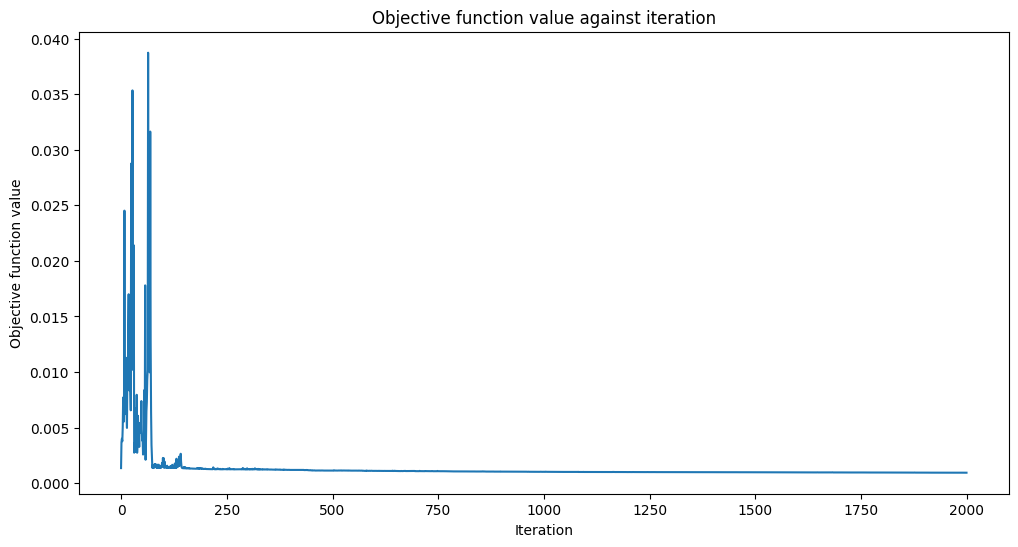

Training score= 0.9787131870928393
Test score= 0.9312466906070981


In [30]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(train_circuits, df_train_enthalpy)
#Replace df_train_angle with list of feature map circuits

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print('Training score=', estimator_classifier.score(train_circuits, df_train_enthalpy))
print('Test score=', estimator_classifier.score(test_circuits, df_test_enthalpy))

# estimator_classifier.save(f'{newpath}/a{ansatz_layers}_m{int(maxiter/1000)}k')

In [28]:
min_ind = f_total.index(min(f_total))
min_x = x_total[min_ind]
print(f_total)
print(accept_total)

est = NeuralNetworkRegressor(
    estimator_qnn, optimizer=COBYLA(maxiter=1), initial_point=min_x)

est.fit(train_circuits, df_train_classes)
print('Training score=', est.score(train_circuits, df_train_enthalpy))
print('Test score=', est.score(test_circuits, df_test_enthalpy))

[np.float64(0.011154223336946368), np.float64(0.004794713795224367), np.float64(0.003026484689230886), np.float64(0.002195921066797683), np.float64(0.0016862535961684202), np.float64(0.0015621675302221981), np.float64(0.0014648479972281688), np.float64(0.001392567636123659), np.float64(0.0013540690699801864), np.float64(0.0013540335180696951)]
[True, True, True, True, True, True, True, True, True, True]
Training score= 0.9692856930574584
Test score= 0.9341276467908158


In [13]:
print(estimator_classifier.predict(test_circuits))
print(df_test_enthalpy)
# print(estimator_classifier.predict_proba(test_circuits))
# print(estimator_classifier.weights)

[[ 0.41141508]
 [ 0.00867094]
 [-0.09539182]
 [-0.3366815 ]
 [-0.19376006]
 [-0.17910867]
 [-0.11734676]
 [-0.21829958]
 [-0.11584543]
 [-0.28256083]]
[ 0.36121673  0.06131179 -0.03707224 -0.33127376 -0.16872624 -0.15541825
 -0.12309886 -0.18726236 -0.11692015 -0.27138783]
